In [1]:
from IPython.core.display import HTML
HTML("""
<style>
code {
    padding:2px 4px !important;
    color: #c7254e !important;
    font-size: 90%;
    background-color: #f9f2f4 !important;
    border-radius: 4px !important;
    color: rgb(138, 109, 59);
    font-weight: bold;
}
mark {
    color: rgb(138, 109, 59) !important;
    font-weight: bold !important;
}
.container { width: 90% !important; }
table { font-size:15px !important; }
</style>
""")

In [2]:
import sys, math, os
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt    
import numpy as np
import statsmodels.formula.api as sm
import scipy.stats
from sklearn import linear_model
from sklearn.metrics import r2_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
import operator

sys.path.insert(0, '../../src/data/')
import utils

%matplotlib inline
%load_ext autoreload  
%autoreload 2  

path_raw = "../../data/raw/beer_reviews"
trolls_file = '../../data/interim/trolls.csv'
random = 42

savefig = False

assert os.path.isfile(os.path.join(path_raw, 'beer_reviews.csv')), "This data file doesn't exist yet, please run through 'make data'"
assert os.path.isfile(trolls_file), "The trolls file doesn't exist yet, please run through analysis 3.0 first!"

# ignore sklearn depreciation warnings :(
import warnings
warnings.filterwarnings('ignore')

# Introduction

The goal of this notebook is to try and answer the question
> If I enjoy a beer's aroma and appearance, which beer style should I try?

In other words, which beer style in general are correlated with the highest scores in `review_aroma` and `review_appearance`?

In [3]:
# LOAD DATA
# we assume the file we're after is a
# single .csv in path_raw
for file in os.listdir(path_raw):
    file = os.path.join(path_raw, file)
    if os.path.isfile(file) and '.csv' in file: 
        dat_raw = pd.read_csv(file, encoding='utf-8') # NOTE: force utf-8 encoding because some beer_styles have accents in them
        
# this file only available if analysis 3.0 is run
trolls = pd.read_csv(trolls_file)

# create new copy of data
# 1. without reviews with missing profilename
# 2. without trolls
dat = dat_raw[(dat_raw.review_profilename.notnull()) & (~dat_raw.review_profilename.isin(trolls))].copy()

# generate new feature as the mean of review_aroma and review_appearance
dat['combo_score'] = dat[['review_aroma', 'review_appearance']].mean(axis=1)

<hr>

## Descriptive stats

In [4]:
# for each beer style, get some descriptive stats for the interested factors
factors = ['review_aroma', 'review_appearance']
label = ['beer_style']
factor_stats = dat[factors + ['combo_score'] + label].groupby('beer_style').agg(['mean','median','std','max'])

factor_stats.columns = ['aroma mean','aroma median','aroma std', 'aroma max',
                       'appearance mean','appearance median','appearance std', 'appearance max',
                       'combo mean','combo median','combo std', 'combo max']

counts = dat.groupby('beer_style').count()[['brewery_id']]
counts.columns = ['num beers']
abv = dat.groupby('beer_style').mean()[['beer_abv']]
abv.columns = ['mean abv']

factor_stats = factor_stats.merge(counts, left_index=True, right_index=True)
factor_stats = factor_stats.merge(abv, left_index=True, right_index=True)

factor_stats.sort_values(('combo mean'), ascending=False).to_csv('../../data/interim/factor_stats.csv', encoding='utf-8')

# naivly sort by mean score and grab top10
factor_stats.sort_values(('combo mean'), ascending=False).head(10)

,aroma mean,aroma median,aroma std,aroma max,appearance mean,appearance median,appearance std,appearance max,combo mean,combo median,combo std,combo max,num beers,mean abv
beer_style,,,,,,,,,,,,,,
American Double / Imperial Stout,4.160604,4,0.570494,5,4.163563,4,0.515692,5,4.162084,4.25,0.446933,5,50696,10.605530
Russian Imperial Stout,4.076571,4,0.542298,5,4.210070,4,0.508619,5,4.143320,4.25,0.434802,5,54120,9.986842
Quadrupel (Quad),4.132493,4,0.544134,5,4.117922,4,0.514125,5,4.125207,4.25,0.448639,5,18084,10.461493
American Double / Imperial IPA,4.097774,4,0.568202,5,4.078882,4,0.469201,5,4.088328,4.00,0.430182,5,85958,9.370207
Gueuze,4.117696,4,0.560120,5,4.034876,4,0.500074,5,4.076286,4.25,0.450927,5,6007,5.598439
American Wild Ale,4.126756,4,0.565143,5,4.005451,4,0.501612,5,4.066104,4.00,0.442322,5,17794,7.713634
Eisbock,4.156778,4,0.528950,5,3.964514,4,0.496758,5,4.060646,4.00,0.412955,5,2663,11.392852
American Barleywine,4.019348,4,0.524654,5,4.036376,4,0.478667,5,4.027862,4.00,0.408577,5,26721,10.703676
Belgian IPA,3.979666,4,0.511232,5,4.075199,4,0.481009,5,4.027432,4.00,0.402156,5,12467,8.349086


The beers above show those that are both highly rated (on average) in aroma and appearance -> these numbers suggest *American Double / Imperial Stout* be the `beet_style` to recommend. It should be noted that *American Double / Imperial IPA* was reviewed more than any other beer, and thus we can be more confident in scores attributed to this beer.

In [5]:
# we will retain only the most highly ranked beers (by aroma and appearance)
# and then rank the beers by the ratio of beers that remain in each category
ranks = dict()
for cutoff in np.arange(4.0,5.1,0.1):
    
    # pull out only those reviews with a score of >= 'cutoff' for aroma and appearance
    score5 = dat[(dat.review_aroma>=cutoff) & (dat.review_appearance>=cutoff)]
    score5_group = score5.groupby('beer_style').count()[['brewery_id']]
    score5_group.columns = ['count_perfect_reviews']
    
    # merge with pre-filtered counts of beers per style
    score5_group = score5_group.merge(counts, left_index=True, right_index=True)
    
    score5_group['ratio'] = score5_group.count_perfect_reviews / score5_group['num beers']  

    # get number of reviews for each beer_style
    reviews = dat.groupby('beer_style').count()[['brewery_id']]
    reviews.columns = ['count_reviews']

    # get number of beers per style
    num_beers = dat.groupby('beer_beerid').agg('first').groupby('beer_style').count()[['brewery_id']]
    num_beers.columns = ['count_beers']

    # merge
    score5_group = score5_group.merge(reviews, left_index=True, right_index=True, how='inner')
    score5_group = score5_group.merge(num_beers, left_index=True, right_index=True, how='inner')

    # sort
    score5_group = score5_group.sort_values('ratio', ascending=False).head(10)

    # NOTE: rank 0 is highest
    rank = {str(style.encode('utf-8').strip()):rank for rank,style in enumerate(score5_group.index.tolist())}
    
    ranks[cutoff] = rank

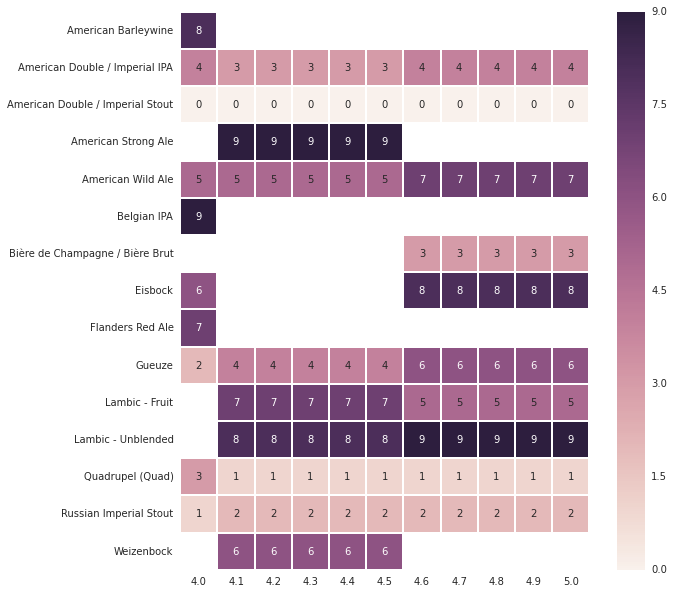

In [6]:
ratings = pd.DataFrame(ranks)
keep_beers = ratings.index
ratings.index = [l.decode('utf-8') for l in ratings.index]

plt.figure(figsize=(10,10))
with sns.axes_style("white"):
    sns.heatmap(ratings, linewidths=.5, square=True, mask=ratings.isnull(), annot=True)
    
plt.savefig('../reports/figures/5.0_beer_style-0.svg')
plt.savefig('../reports/figures/5.0_beer_style-0.png')

The heatmap above shows how the highest rated `beer_style` rank (0 is highest rank) as the cutoff value for score is increated from 4 to 5. We can see that *Quadrupel (Quad)*, *American Double/Imperial Stout* and *Russian Imperial Stout* consitently rank as the highest or second-highest rated `beer_style` all throughout the range of score cutoff.

In general, the following beers show up highly ranked (top 5) across most cutoffs:
- Quadrupel (Quad)
- American Double/Imperial Stout
- Russian Imperial Stout
- American Double / Imperial IPA
- Gueuze

It's interesting to note that the *Biere Brut* shows up highly ranked only at cutoffs above 4.5.

<hr>

## Machine learning classification

Let's use some machine learning to generate a model and then feed it a prediction with high scores for `review_aroma` and `review_appearance` to see which beer it predicts.

In [9]:
param = {'n_estimators':[10,100], 'max_features':['auto',1/3.0], 'max_depth':[None,10,20]}
mdl = RandomForestClassifier(n_jobs=-1, random_state=random, oob_score=True)

# commented out because computationally intensive
# clf = GridSearchCV(mdl, param, n_jobs=-1)
# clf.fit(dat[factors], np.ravel(dat[label]))
# print clf.best_params_, clf.best_score_

In [10]:
dat_train, dat_test = utils.split_data(dat, [0.8,0.2])
mdl = RandomForestClassifier(n_jobs=-1, random_state=random, n_estimators=100)
mdl.fit(dat_train[factors], np.ravel(dat_train[label]))
mdl.score(dat_test[factors], np.ravel(dat_test[label]))

0.091043769345697773

Using the full data set leads to low accuracy rates - let's try and subset to those beers we are already confident about (see list of beers above).

<mark>The hyper-parameter fine-tuning wasn't exhaustively done; it's computationally intensive and will probably only gain use slight accuracy gains. So, I'm moving on with the best parameters found above.</mark>

In [62]:
top_beers = keep_beers

dat_train, dat_test = utils.split_data(dat[dat.beer_style.isin(top_beers)], [0.8,0.2])
mdl = RandomForestClassifier(n_jobs=-1, random_state=random, n_estimators=100)
mdl.fit(dat_train[factors], dat_train[label])
print 'Overall model accuracy: ', mdl.score(dat_test[factors], np.ravel(dat_test[label]))

# predict on hypothetical score requests
for score in np.arange(4.0,5.1,0.1):
    pred, prob = mdl.predict([score,score]), mdl.predict_proba([score,score])[0]
    probs = '\n>> '.join([str(l.split(' / ')[-1]) + ': ' + str(round(prob[i],2)) for i,l in enumerate(mdl.classes_)])
    print 'Predict score [%s, %s], model predicts: %s (%.2f)\n>> %s' %(score,score,list(pred)[0],max(prob),probs)

Overall model accuracy:  0.262261274993
Predict score [4.0, 4.0], model predicts: American Double / Imperial IPA (0.26)
>> American Barleywine: 0.09
>> Imperial IPA: 0.26
>> Imperial Stout: 0.13
>> American Strong Ale: 0.1
>> American Wild Ale: 0.05
>> Belgian IPA: 0.04
>> Eisbock: 0.01
>> Flanders Red Ale: 0.02
>> Gueuze: 0.02
>> Lambic - Fruit: 0.03
>> Lambic - Unblended: 0.0
>> Quadrupel (Quad): 0.05
>> Russian Imperial Stout: 0.15
>> Weizenbock: 0.03
Predict score [4.1, 4.1], model predicts: American Double / Imperial IPA (0.26)
>> American Barleywine: 0.09
>> Imperial IPA: 0.26
>> Imperial Stout: 0.13
>> American Strong Ale: 0.1
>> American Wild Ale: 0.05
>> Belgian IPA: 0.04
>> Eisbock: 0.01
>> Flanders Red Ale: 0.02
>> Gueuze: 0.02
>> Lambic - Fruit: 0.03
>> Lambic - Unblended: 0.0
>> Quadrupel (Quad): 0.05
>> Russian Imperial Stout: 0.15
>> Weizenbock: 0.03
Predict score [4.2, 4.2], model predicts: American Double / Imperial IPA (0.26)
>> American Barleywine: 0.09
>> Imperial I

The RF model tends to predict in the same way as the results we saw in the heatmap, except for the range of cutoffs up to 4.2 (RF predicts *America IPA*, whereas heatmap shows *Imperial Stout*). It should be noted however, that the probabilities aren't very high, except, perhaps, for those predicting *American IPA*.

In [60]:
mdl = LogisticRegression(random_state=random, n_jobs=-1)
mdl.fit(dat_train[factors], np.ravel(dat_train[label]))
print 'Overall model accuracy: ', mdl.score(dat_test[factors], np.ravel(dat_test[label]))

# predict on hypothetical score requests
for score in np.arange(4.0,5.1,0.1):
    pred, prob = mdl.predict([score,score]), mdl.predict_proba([score,score])[0]
    probs = '\n>> '.join([str(l.split(' / ')[-1]) + ': ' + str(round(prob[i],2)) for i,l in enumerate(mdl.classes_)])
    print 'Predict score [%s, %s], model predicts: %s (%.2f)\n>> %s' %(score,score,list(pred)[0],max(prob),probs)

Overall model accuracy:  0.258420753758
Predict score [4.0, 4.0], model predicts: American Double / Imperial IPA (0.26)
>> American Barleywine: 0.08
>> Imperial IPA: 0.26
>> Imperial Stout: 0.15
>> American Strong Ale: 0.1
>> American Wild Ale: 0.05
>> Belgian IPA: 0.04
>> Eisbock: 0.01
>> Flanders Red Ale: 0.02
>> Gueuze: 0.02
>> Lambic - Fruit: 0.03
>> Lambic - Unblended: 0.0
>> Quadrupel (Quad): 0.05
>> Russian Imperial Stout: 0.15
>> Weizenbock: 0.03
Predict score [4.1, 4.1], model predicts: American Double / Imperial IPA (0.26)
>> American Barleywine: 0.08
>> Imperial IPA: 0.26
>> Imperial Stout: 0.15
>> American Strong Ale: 0.1
>> American Wild Ale: 0.05
>> Belgian IPA: 0.04
>> Eisbock: 0.01
>> Flanders Red Ale: 0.02
>> Gueuze: 0.02
>> Lambic - Fruit: 0.03
>> Lambic - Unblended: 0.0
>> Quadrupel (Quad): 0.05
>> Russian Imperial Stout: 0.16
>> Weizenbock: 0.03
Predict score [4.2, 4.2], model predicts: American Double / Imperial IPA (0.26)
>> American Barleywine: 0.08
>> Imperial I